In [18]:
import gym_bandits
import gym
import numpy as np
import random

In [19]:
class BanditAgent():
    def __init__(self, epsilon):
        
        self.epsilon = epsilon
        
        self.rewardsPerAction = np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ])
        self.actionCounts = np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ])
    
    def Q(self, a):
        if self.actionCounts[a] == 0:
            return 0
        
        estimated_value = self.rewardsPerAction[a] / self.actionCounts[a]
        return estimated_value
    
    def getAllValueEstimates(self):
        
        estimates = np.zeros((9,))
        for action in range(len(estimates)):
            estimates[action] = self.Q(action)
        
        return estimates
        
    
    def greedy_policy(self):
        action = np.argmax(self.getAllValueEstimates())
        return action
    
    def e_greedy_policy(self):
        if random.random() < self.epsilon:
            return random.randint(0, 9)
        else:
            return self.greedy_policy()
    
    def train(self, action_taken, reward):
        self.rewardsPerAction[action_taken] += reward
        self.actionCounts += 1
        
        

In [20]:
class BanditAgentRollingPredictions():
    def __init__(self, epsilon, step_size=None):
        
        self.step_size = step_size
        self.epsilon = epsilon
        
        self.actionCounts = np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ])
        
        self.valuePredictions = np.array([
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.
        ])
        
        
        
    def greedy_policy(self):
        action = np.argmax(self.valuePredictions)
        return action
    
    def e_greedy_policy(self):
        if random.random() < self.epsilon:
            return random.randint(0, 9)
        else:
            return self.greedy_policy()
    
    def train(self, action_taken, reward):
        self.actionCounts[action_taken] += 1
        
        error = (reward - self.valuePredictions[action_taken])
        lr = self.step_size
        
        new_Q = self.valuePredictions[action_taken] + lr * error
        
        self.valuePredictions[action_taken] = new_Q
        

In [21]:
env = gym.make("BanditTenArmedGaussian-v0")
env.reset()

0

In [22]:
game_length = 9000
agent = BanditAgentRollingPredictions(0.1, step_size=0.1)

rewards = []

for i in range(game_length):
    action = agent.e_greedy_policy()
    _, reward, _, _ = env.step(action)
    agent.train(action, reward)
    rewards.append(reward)

In [23]:
from matplotlib import pyplot as plt

1.2219857730385448

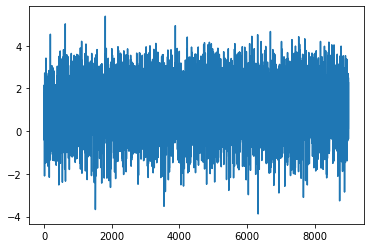

In [24]:
plt.plot(rewards)
np.mean(rewards)

In [25]:
env.r_dist

[[0.7921839461642128, 1],
 [0.1358146889658926, 1],
 [-0.5224096109399193, 1],
 [-0.7239210922379551, 1],
 [-0.84703730418092, 1],
 [-0.5833329041323305, 1],
 [-0.0010410448338474942, 1],
 [-1.1546106567557037, 1],
 [-0.33041667651943474, 1],
 [1.4139445731024376, 1]]

In [26]:
agent.valuePredictions

array([ 0.45888901,  0.08362395, -0.44564073, -0.82608588, -0.74771023,
       -0.76347534,  0.34222677, -1.34704707, -0.38638462,  1.37558749])

In [27]:
2.0004571277448653 * 0.9

1.8004114149703787

*Exercise 2.5 (programming)* Design and conduct an experiment to demonstrate the
difficulties that sample-average methods have for nonstationary problems. Use a modified
version of the 10-armed testbed in which all the q\*(a) start out equal and then take
independent random walks (say by adding a normally distributed increment with mean
zero and standard deviation 0.01 to all the q\*(a) on each step). Prepare plots like
Figure 2.2 for an action-value method using sample averages, incrementally computed,
and another action-value method using a constant step-size parameter, alpha = 0.1. Use
epsilon = 0.1 and longer runs, say of 10,000 steps.

In [28]:
env2 = gym.make("BanditTenArmedNonstationaryConstantGaussian-v0")
env2.r_dist = [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]
game_length = 100_000
agent = BanditAgentRollingPredictions(0.1, step_size=0.1)

rewards = []

for i in range(game_length):
    action = agent.e_greedy_policy()
    _, reward, _, _ = env2.step(action)
    agent.train(action, reward)
    rewards.append(reward)

2.6823185633496327

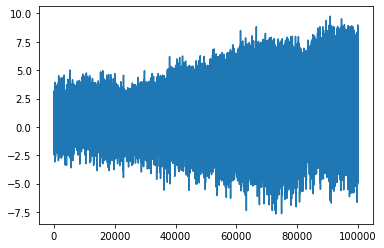

In [29]:
plt.plot(rewards)
np.mean(rewards)

In [30]:
class UnbiasedConstantStepSizeBandit():
    def __init__(self, epsilon, step_size_alpha=None):
        
        self.step_size = step_size_alpha
        self.epsilon = epsilon
        
        self.actionCounts = np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ])
        
        self.valuePredictions = np.array([
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.
        ])
        
        self.currentO = 0
        
        
    def greedy_policy(self):
        action = np.argmax(self.valuePredictions)
        return action
    
    def e_greedy_policy(self):
        if random.random() < self.epsilon:
            return random.randint(0, 9)
        else:
            return self.greedy_policy()
    
    def train(self, action_taken, reward):
        self.actionCounts[action_taken] += 1
        self.currentO = self.currentO + self.step_size * (1 - self.currentO)
        
        error = (reward - self.valuePredictions[action_taken])
        
        lr = self.currentO
        
        new_Q = self.valuePredictions[action_taken] + lr * error
        
        self.valuePredictions[action_taken] = new_Q
        

In [35]:
env3 = gym.make("BanditTenArmedNonstationaryConstantGaussian-v0", step_size=0.1)
# env3.r_dist = [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]
game_length = 100_000
agent = UnbiasedConstantStepSizeBandit(0.1, step_size_alpha=0.1)

rewards = []
average_qs = []

for i in range(game_length):
    action = agent.e_greedy_policy()
    average_qs.append(np.sum([arm[0] for arm in env3.r_dist])/10)

    _, reward, _, _ = env3.step(action)
    agent.train(action, reward)
    rewards.append(reward)

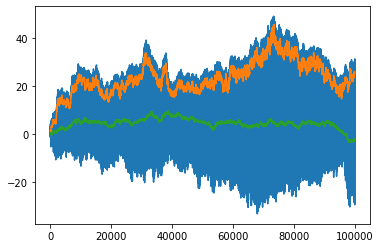

In [37]:

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(rewards)
moving_avgs = moving_average(rewards, n=100)


plt.plot(moving_avgs)
plt.plot(average_qs)

np.mean(rewards)

plt.show()